In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hex2color, rgb2hex
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import gridspec
from scipy.optimize import curve_fit

In [3]:
import popoff
from pop_off_functions import save_figure
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

user_paths_dict = popoff.loadpaths.loadpaths()
sys.path.append(user_paths_dict['vape_path'])
from utils.utils_funcs import d_prime

figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0'

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py
/home/jrowland/Documents/code/Vape


In [4]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)



## Panels and b are rob's from fens figure

## Panel C

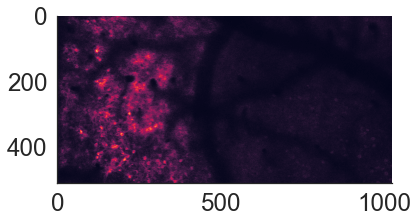

In [5]:
# I'm currently not using the image out of python, I did the central pixel selection and png saving in imagej.
# But this is the path to the correct image used in figure 1

tiff_path = os.path.expanduser('~/mnt/qnap/Data/2020-02-21/STA/2020-02-21_RL070_t-001/'
                               '2020-02-21_RL070_t-001_17Stims_STA_dF_MaxResponseImage.tif')

image = tifffile.imread(tiff_path)
# Select the central 512 lines
image = image[int(512 - (1024 / 4)):int(512 + (1024 / 4)), :]
plt.imshow(image)

## Panel d

In [6]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [7]:
print(msm.plot_string('Both', is_plot=False))

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse J064, run 11', 'Mouse J064, run 14', 'Mouse RL070, run 28', 'Mouse RL070, run 29', 'Mouse RL117, run 29', 'Mouse RL117, run 30', 'Mouse RL123, run 22', 'Mouse RL116, run 32', 'Mouse RL116, run 33']
Cells in region Both are includedpre-frames spans -1.97 to -0.1 inclusive
post-frames spans 0.83 to  6.0 inclusive


In [8]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [9]:
def get_plot_trace(lm, targets=False, region='s1', remove_easy=False):
    
    global COLOR_IDX
    
    if targets:
        mask = ~lm.session.is_target
    else:
        mask = lm.session.is_target
    
    flu = lm.flu[lm.region_map[region], :, :]
    mask = mask[lm.region_map[region], :, :]
    
    # Take out catch trials
    if remove_easy:
        stim_idx = lm.session.photostim == 1
    else:
        stim_idx = lm.session.photostim != 0
        
    flu = flu[:, stim_idx, :]
    mask = mask[:, stim_idx, :]
    
    # Fluoresence averaged across cells with (non)targets filtered
    flu = np.ma.array(flu, mask=mask).mean(0)
    flu = baseline_subtraction(flu, lm)
    
    # x axis in seconds aligned to stim
    x_axis = (np.arange(flu.shape[1]) - max(np.where(lm.pre)[0])) / 30
    label = 'Targets' if targets else f'Non Targets {region.upper()}'
    
    # Need to plot pre and post as two separate lines cos seaborn is uncooperative
    for idx_frames in [lm.pre, lm.post]:
        
        data = flu[:, idx_frames]
        
        df = pd.DataFrame(data).melt()
        df['time (seconds)'] = np.repeat(x_axis[idx_frames], data.shape[0])
        
        sns.lineplot(x='time (seconds)', y='value', data=df, color=sns.color_palette()[COLOR_IDX],
                    label=label)
        label = None
        
    plt.ylabel(r'$\Delta$F/F')
    plt.ylim(-0.07, 0.4)
    plt.xlim(-1,6)
    legend = plt.legend(bbox_to_anchor=(1.4, 1.3))
    legend.get_frame().set_facecolor('none')
    COLOR_IDX += 1 
    

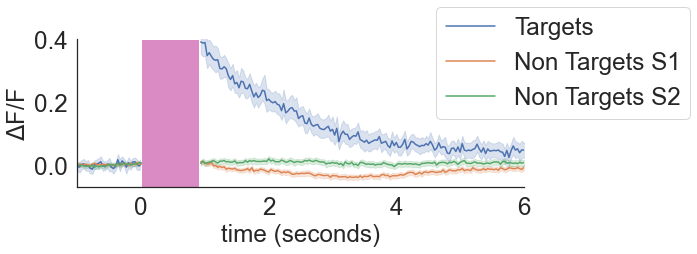

In [63]:
lm = msm.linear_models[6]

COLOR_IDX = 0  # Filthy global just to keep the pre and post color consistent

plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
get_plot_trace(lm, targets=True, region='s1')
plt.axvspan(0, 0.9, facecolor=sns.color_palette()[6])
# plt.subplot(2,1,2)
get_plot_trace(lm, targets=False, region='s1')
get_plot_trace(lm, targets=False, region='s2')

plt.axvspan(0, 0.9, facecolor=sns.color_palette()[6])

save_figure('Figure1PanelD', figure_path)

## Panels E and F are from fens poster

## Panel G

In [10]:
def get_subset_dprime(session):
    
    assert session.trial_subsets.shape == session.outcome.shape
    
    fp_rate = sum(session.outcome=='fp') / (sum(session.outcome=='fp') + sum(session.outcome=='cr'))
    subset_dprimes = []
#     for subset in [[5, 10], [20, 30], [40, 50], [150]]:
    for subset in [[5],[10],[20],[30],[40],[50], [150]]:
        idx = np.isin(session.trial_subsets, subset)
        outcome = session.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        subset_dprimes.append(d_prime(hit_rate, fp_rate))
#         subset_dprimes.append(hit_rate)
    
    return subset_dprimes

In [11]:
subset_dprimes = [get_subset_dprime(lm.session) for lm in msm.linear_models]
subset_dprimes = np.array(subset_dprimes)

In [12]:
# psychometric function
def pf(x, max_value, alpha, beta):
    ''' Max value: max value of sigmoid
        alpha: x_axis midpoint
        beta: the growth rate
    '''
    return max_value / (1 + np.exp( -(x-alpha)/beta)) 

In [14]:
subset_dprimes.shape

(10, 7)

/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


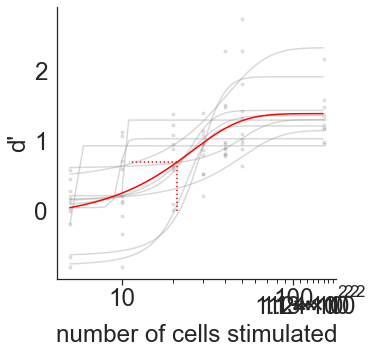

In [13]:
np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(5,5))

# x_axis = [7.5, 25, 45, 150]
x_axis = [5,10,20,30,40,50,150]
all_dp = []
n = 0

min_x = 5
for idx, dp in enumerate(subset_dprimes):
    
    all_dp.append(dp)
    
    # Subtract the min val from the data and then add it 
    # back on later, to get the fit below 0 if required
    min_val = min(dp)
    dp = dp - min_val
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[max(dp), 50, 200])
    
    dp = dp + min_val

    plt.plot(x_axis, dp, '.', color='grey', alpha=0.2)
    
    plt.plot(np.arange(min_x ,max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt) + min_val, color='grey', alpha=0.3)
    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])

min_val = min(y)

y = y - min_val
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[max(y), 50, 200])

y = y + min_val
plt.plot(np.arange(min_x, max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt) + min_val, color='red')

plt.tick_params(
    axis='x',
    which='both',
    bottom=True
)


plt.gca().tick_params(which='minor', labelbottom=True)

ax = plt.gca()

ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))


plt.xscale('log')
plt.ylabel('d\'')
plt.xlabel('number of cells stimulated', fontname='Arial')


# Centre point of the rescaled sigmoid.
# Assumes sigmoid min is 0. Which is approx true here
midpoint = (popt[0]+min_val)/2

# Empirically find the x-axis position matching the midpoint
x_range = np.arange(min_x, max(x_axis))
res = pf(x_range, *popt) + min_val
n_cells_mid = x_range[np.argmin(np.abs(res-midpoint))]

# Line doesn't go far enough but just extend in illustrator
plt.vlines(x=n_cells_mid, ymin=0, ymax=midpoint, color='red', ls=':')
plt.hlines(y=midpoint, xmin=n_cells_mid, xmax=popt[1], color='red', ls=':')

ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10))

ticks = [10, 100]
plt.xticks(ticks, ticks)

save_figure('Figure1PanelG', figure_path)

In [143]:

print(ax.xaxis.get_minor_locator()

In [108]:
np.min(subset_dprimes.ravel())

-0.7921081583857676

## Raw data of the above figure

In [ ]:
plt.figure(figsize=(5,5))
x_axis = [7.5, 25, 45, 150]

for dp in subset_dprimes:
    plt.plot(x_axis, dp, marker='o', color='blue', markersize=10)
plt.xlabel('n cells stimmed')
plt.ylabel('d\'')

## Lick raster -> reorder the panel letters

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [ ]:
def trial_binner(arr):
    
    group_dict = {
        
        0: '0',
        5: '5-10',
        10: '5-10',
        20: '20-30',
        30: '20-30',
        40: '40-50',
        50: '40-50',
        150: '150'
        
    }

    return np.array([group_dict[a] for a in arr])

In [ ]:
def lick_raster(lm):
    
    COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    session = lm.session
    binned_licks = np.array(session.spiral_lick)[lm.session.nonnan_trials]
    trial_subsets = session.trial_subsets
    outcome = session.outcome
    
    assert len(binned_licks) == len(trial_subsets) == len(outcome)
    
    
    # Current putting too_soons back in as hits. You can also 
    # remove them completely 
    ## Its currently called 'too_' for some reason
    
    outcome[outcome=='too_'] = 'hit'
    
    # Sort variables by whether the number of cells stimmed
    trial_idxs = np.argsort(trial_subsets, kind='mergesort')
    
    sorted_licks = binned_licks[trial_idxs]
    sorted_outcome = outcome[trial_idxs]
    sorted_subsets = trial_subsets[trial_idxs]
    sorted_subsets = trial_binner(sorted_subsets)
        
    # Map a plot color to each subset size
    #colors = ['black', 'dimgrey', 'darkgrey', 'silver', 'pink']
    colors = ['pink'] * 4
    colors.append('c')
    colors = ['black'] * 5
    subsets = ['150', '40-50', '20-30', '5-10', '0']
    
    color_map = {}
    for i, sub in enumerate(subsets):
        color_map[sub] = colors[i] 
    subset_colors = [color_map[i] for i in sorted_subsets]
    
    fig = plt.figure(figsize=(5,10))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    ax0 = plt.subplot(gs[0]) 
    ax1 = plt.subplot(gs[1])
    
    # Plot lick rasters 
    line_pos = []
    
    reaction_times = []
    for i, rast in enumerate(sorted_licks):

        color=subset_colors[i]
        y_axis = np.ones(len(rast)) + i

        if sorted_subsets[i] != sorted_subsets[i-1] and i != 0:
            ax0.axhline(y=i, ls='--', color='black')
            line_pos.append(i)
        try:
            point = rast[0] / 1000
            if point <= 1:
                marker = '.'
                fillstyle = 'full'
            else:
                marker = '.'
                fillstyle = 'none'
            ax0.plot(point, y_axis[0], marker=marker,
                     fillstyle=fillstyle, c=color, markersize=8.5)
            reaction_times.append(rast[0])
        except IndexError:
            reaction_times.append(np.nan)
            pass

    # Get positions of dividing lines so know where to put y tick labels
    line_pos.insert(0,0)
    line_pos.append(len(sorted_subsets))
    subset_centre = [(line_pos[i] + line_pos[i+1]) / 2 for i in range(len(line_pos)-1)]
    
    # Setup raster axis 
    ax0.fill_between([0,1], 0, len(sorted_licks), color='gainsboro', alpha=0.5)
    ax0.set_xlim((0,1.95))
    ax0.set_xlabel('Time (s)')
    ax0.set_ylim((0,len(sorted_licks)+1))
    ax0.set_yticks(subset_centre)
    ax0.set_yticklabels(np.flip(subsets))
    ax0.set_ylabel('Number of Cells Stimulated')
    sns.despine()
    
    # Map trial types to ints so can express as colormap
    int_map = {
        'hit': 3,
        'miss': 2,
        'fp': 1,
        'cr': 0
    }
    
    int_mapped = [int_map[out] for out in np.flip(sorted_outcome)]        
    bar_width = 10
    bar_data = np.stack([int_mapped for _ in range(bar_width)], axis=1)
    
    to_rbga = lambda col: hex2color(col)
    cols =  [COLORS[0], COLORS[1],
             CB_color_cycle[7], COLORS[2]]
    
    cm = LinearSegmentedColormap.from_list('hit_miss', cols, N=4)
    
    # Build the colorbar
    im = ax1.imshow(bar_data, cmap=cm)
    ax1.set_xticks([])
    trial_scale = [0, len(sorted_outcome)]
    ax1.set_yticks(trial_scale)
    # This gives you the trial number on the axis
#     ax1.set_yticklabels([('#'+str(t)) for t in np.flip(trial_scale)])
    ax1.set_yticklabels([])
    
    fontsize = 18
    plt.text(18, len(sorted_outcome)/3, 'Hit', color=cols[3], fontsize=fontsize)
    plt.text(18, len(sorted_outcome)/1.7, 'Miss', color=cols[2], fontsize=fontsize)
    plt.text(18, len(sorted_outcome)/1.22, 'Correct\nRejection', color=cols[0], fontsize=fontsize)
    plt.text(18, len(sorted_outcome)/1.01, 'False\nPositive', color=cols[1], fontsize=fontsize)

In [ ]:
lm = msm.linear_models[2]
lick_raster(lm)
save_figure('Lick_raster', figure_path)

## Hex color codes for the seaborn palette

In [ ]:
pal = sns.color_palette()
print(pal.as_hex())

In [ ]:
pal

In [ ]:
for lm in msm.linear_models:
    session = lm.session
    print(session)
    print(len(session.outcome))
    print('\n')

In [ ]:

np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(10,10))

x_axis = [7.5, 25, 45, 150]
# x_axis = [5,10,20,30,40,50,150]
all_dp = []
n = 0

min_x = 5
for idx, dp in enumerate(subset_dprimes):
    
    all_dp.append(dp)
    plt.plot(x_axis, dp, '.', color='grey', alpha=1, markersize=10)
    
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[max(dp), 50, 200])
    
    plt.plot(np.arange(min_x ,max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='grey', alpha=0.8)
    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[max(y), 50, 200])
plt.plot(np.arange(min_x, max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='red')

plt.xscale('log')
plt.ylabel('d\'')
plt.xlabel('number of cells stimulated', fontname='Arial')

ticks = [5, int(popt[1]), 100, 150]
ticks = [10,100]

# plt.axvline(x=popt[1], ymax=popt[0]/2, color='red', ls=':')
plt.vlines(x=popt[1], ymin=0, ymax=popt[0]/2, color='red', ls=':')
plt.hlines(y=popt[0]/2, xmin=0, xmax=popt[1], color='red', ls=':')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(which='minor', length=1, color='r')

In [ ]:
session = msm.linear_models[0].session
session.__dict__.keys()